# Train RNN to lick rate behaviors for GO-NOGO task

### Matrix of connections

## Import packages

In [84]:
import os
import re
import warnings
import pickle
import yaml
import datetime
from copy import deepcopy

import math
import numpy as np
import pandas as pd
from scipy import ndimage
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import init
from torch.nn import functional as F

import matplotlib.pyplot as plt
import seaborn as sns

if 'rnn' in os.getcwd():
    os.chdir('..')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [85]:
root_data_dir = 'data/tfarnpin/rnn'
main_root = 'data/tfarnpin'

In [86]:
behavior_df = pd.read_parquet(
    root_data_dir + '/lick-rate.pq.zst'
)

min_ntps = behavior_df['time'].apply(len).min()
behavior_df['time'] = behavior_df['time'].apply(lambda x: x[:min_ntps])
behavior_df['lick_rate'] = behavior_df['lick_rate'].apply(lambda x: x[:min_ntps])

assert behavior_df['time'].apply(len).nunique() == 1
assert behavior_df['lick_rate'].apply(len).nunique() == 1
# behavior_df

In [87]:
behavior_df['mean_lr_action_10s'] = behavior_df.apply(
    lambda x: np.mean(x['lick_rate'][(x['time'] >= 10) & (x['time'] <= 10 + 10)]),
    axis=1
)
behavior_df['mean_lr_action_5s'] = behavior_df.apply(
    lambda x: np.mean(x['lick_rate'][(x['time'] >= 10) & (x['time'] <= 10 + 5)]),
    axis=1
)
behavior_df.groupby('outcome')['mean_lr_action_10s'].describe()

behavior_df.groupby('outcome')['mean_lr_action_5s'].describe()

,count,mean,std,min,25%,50%,75%,max
outcome,,,,,,,,
correct_rejection,768.0,0.042240,0.152503,0.000000,0.000000,0.000000,0.000000,1.499125
false_alarm,482.0,0.842225,0.667360,0.145384,0.392157,0.593183,1.059991,4.302589
hit,1065.0,3.144977,1.994998,0.000000,1.895434,3.127346,4.354360,10.954603
miss,175.0,0.001862,0.011694,0.000000,0.000000,0.000000,0.000000,0.086574


In [88]:
task_config = dict(
    clock = np.round(behavior_df.iloc[0]['time'],1), # need only 1 decimal precision
    stim_onset = float(round(behavior_df.iloc[0]['stim_onset'])),
    stim_offset = float(round(behavior_df.iloc[0]['stim_offset'])),
    action_onset = float(round(behavior_df.iloc[0]['wait_for_lick_onset'])),
    go_period = 10.0,
    nogo_period = 5.0,
    lick_rate_thres = 0.5,
    go_stim = ['CS+1', 'CS+2'],
    nogo_stim = ['CS-1', 'CS-2'],

    go_label = 1,
    nogo_label = 0,
    stim_index_map = {
        'CS+1':0,
        'CS+2':1,
        'CS-1':2,
        'CS-2':3
    },
)

task_config['dt'] = np.round(np.mean(np.diff(task_config['clock'])),1)
task_config['num_time_points'] = len(task_config['clock'])
task_config['go_offset'] = task_config['action_onset'] + task_config['go_period']
task_config['nogo_offset'] = task_config['action_onset'] + task_config['nogo_period']

task_config['go_loc'] = (
    (task_config['clock'] >= task_config['action_onset']) &
    (task_config['clock'] <= task_config['go_offset'])
)
task_config['nogo_loc'] = (
    (task_config['clock'] >= task_config['action_onset']) &
    (task_config['clock'] <= task_config['nogo_offset'])
)

# task_config

def generate_inputs(stim_name, task_config):
    # inputs: time x channel
    stidx_map = task_config['stim_index_map']
    onset = task_config['stim_onset']
    offset = task_config['stim_offset']

    task_time = task_config['clock']

    inputs = np.zeros((
        task_config['num_time_points'],
        len(stidx_map),
    ))

    inputs[
        (task_time >= onset) & (task_time <= offset),
        stidx_map[stim_name],
    ] = 1.0

    return inputs


source_dataset = (
    behavior_df.query(
        'action == "correct" and ('
            '(outcome == "correct_rejection" and mean_lr_action_5s <= 0.5) or '
            '(outcome == "hit" and mean_lr_action_10s > 0.5)'
        ')'
    )
    .groupby('stim_name_value')
    .sample(
        n=350,
        random_state=2025
    )
    .filter([
        'stim_id', 'stim_name_value', 'stim_valence',
        'trial_type', 'outcome', 'has_reward', 'action',
        'time', 'lick_rate',
    ])
    .rename(columns={'lick_rate': 'output'})
    .reset_index(drop=True)
)

source_dataset['label'] = source_dataset['trial_type'].map({
    'GO': task_config['go_label'],
    'NOGO': task_config['nogo_label']
})

source_dataset['inputs'] = source_dataset['stim_name_value'].apply(
    lambda x: generate_inputs(x, task_config)
)

# source_dataset.head(5)
print(True)

True


## Model & Experiment codes

### Generate Batch Dataset

In [89]:
def generate_batch_dataset(
    source_dataset,
    batch_size=16,
    model_ready=False,
    device=None,
    sigma_signal=None, # keep ~ 0.2
    sigma_background=None, # keep ~ 0.1
):
    ds = source_dataset.sample(n=batch_size)

    # time x batch x channel
    inputs = np.stack(ds['inputs'].to_list()).transpose(1,0,2)

    # add multiplicative noise to signal
    if sigma_signal is not None:
        assert sigma_signal > 0 and sigma_signal < 1, 'sigma_signal should be between 0 and 1'
        mul_noise_signal = np.random.uniform(
            1 - sigma_signal,
            1 + sigma_signal,
            (1, inputs.shape[1], 1)
        )

        inputs = inputs * mul_noise_signal

    # add additive background noise
    if sigma_background is not None:
        add_noise_background = np.random.randn(*inputs.shape) * sigma_background
        inputs = inputs + add_noise_background

    # time x batch
    outputs = np.vstack(ds['output'].to_list()).T

    # batch
    labels = ds['label'].to_numpy()

    # convert to torch & send to device
    if model_ready:
        inputs = torch.from_numpy(inputs).type(torch.float)
        outputs = torch.from_numpy(outputs.flatten()).type(torch.float)
        labels = torch.from_numpy(labels).type(torch.long)

        # send to device
        if device is not None:
            inputs = inputs.to(device)
            outputs = outputs.to(device)
            labels = labels.to(device)

    return inputs, outputs, labels

# inputs, outputs, labels = generate_batch_dataset(source_dataset, task_config)
# inputs.shape, outputs.shape, labels.shape

def compute_batch_accuracy(outputs, labels, task_config):
    output_thres = task_config['lick_rate_thres']

    go_label = task_config['go_label']
    nogo_label = task_config['nogo_label']

    go_loc = task_config['go_loc']
    nogo_loc = task_config['nogo_loc']

    go_outputs = outputs[go_loc].mean(axis=0).squeeze() > output_thres
    nogo_outputs = outputs[nogo_loc].mean(axis=0).squeeze() <= output_thres

    num_correct = (
        go_outputs[labels == go_label].sum() +
        nogo_outputs[labels == nogo_label].sum()
    )

    accuracy = 100.0 * num_correct / len(labels)

    return accuracy

In [90]:
### Design Model

### Weight Matrix

In [91]:
# ─── config loader (cfg) ────────────────────────────────────────────────
def load_config(path: str) -> dict:
    with open(path, "r") as f:
        cfg = yaml.safe_load(f)
    cfg["connectivity_df"] = pd.DataFrame(cfg["connectivity"]).T
    return cfg

# ─── CTRNN cell (unchanged except for buffer registration) ────────
class CTRNN(nn.Module):
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 mask, 
                 neuron_signs,
                 tau=100.0, 
                 dt=None, 
                 max_hidden_activity=10.0):
        
        super().__init__()
        self.mask = mask
        self.register_buffer("neuron_signs", neuron_signs.float())
        self.register_buffer("alpha",
             torch.tensor((dt / tau) if dt is not None else 1.0))
        self.register_buffer("oneminusalpha", 1.0 - self.alpha)
        self.max_hidden_activity = max_hidden_activity

        self.input2h = nn.Linear(input_size,  hidden_size)
        self.h2h     = nn.Linear(hidden_size, hidden_size)

        self.apply_mask()
        self.apply_dale()

    # dale clamp ---------------------------------------------------
    def apply_dale(self):
        with torch.no_grad():
            exc = self.neuron_signs ==  1
            inh = self.neuron_signs == -1
            self.h2h.weight.data[exc] = torch.clamp_min(
                self.h2h.weight.data[exc], 0.0)
            self.h2h.weight.data[inh] = torch.clamp_max(
                self.h2h.weight.data[inh], 0.0)
            self.h2h.bias.data[exc]   = torch.clamp_min(self.h2h.bias.data[exc], 0.0)
            self.h2h.bias.data[inh]   = torch.clamp_max(self.h2h.bias.data[inh], 0.0)

    # struct mask ----------------------------------------------
    def apply_mask(self):
        self.input2h.weight.data.mul_(self.mask["i2h_w"])
        self.input2h.bias .data.mul_(self.mask["i2h_b"])
        self.h2h.weight.data.mul_(self.mask["h2h_w"])

    # recurrence ----------------------------------------------------
    def recurrence(self, x_t, h_prev):
        pre = self.input2h(x_t) + self.h2h(h_prev)
        h   = torch.relu(self.oneminusalpha*h_prev + self.alpha*pre)
        return torch.clamp(h, max=self.max_hidden_activity)

    def forward(self, seq, h0=None):
        if h0 is None:
            h = torch.zeros(seq.size(1), self.h2h.weight.size(0), device=seq.device)
        else:
            h = h0
        outs = []
        for t in range(seq.size(0)):
            self.apply_mask()
            h = self.recurrence(seq[t], h)
            outs.append(h)
        return torch.stack(outs), h

# ─── RNNNet ───────────────────────────────────────────────
class RNNNet(nn.Module):
    def __init__(self, cfg: dict):
        super().__init__()
        self.cfg = cfg

        # ---------- build region slices -
        regions = cfg["regions"]
        self.pop_slices, cursor = {}, 0
        for name, rcfg in regions.items():
            n = rcfg["num_neurons"] #?
            self.pop_slices[name] = slice(cursor, cursor+n)
            cursor += n
        hidden_size = cursor #?
        self.cell_vec = sum(([k]* (s.stop-s.start) for k,s in self.pop_slices.items()), [])

        # ---------- Dale signs -
        signs = torch.ones(hidden_size)
        for name, rcfg in regions.items():
            sl = self.pop_slices[name]
            k  = int(rcfg.get("inh_frac", 0.2)*(sl.stop-sl.start))
            signs[sl][:k] = -1
        self.neuron_signs = signs

        # ---------- mask construction -
        self.mask = self._build_masks(cfg, hidden_size)

        # ---------- core cell & read-
        dyn = cfg["cell_dynamics"]
        io  = cfg["io"]
        self.rnn = CTRNN(io["input_size"], hidden_size, self.mask, self.neuron_signs,
                         tau=dyn["tau"], dt=dyn["dt"])
        self.fc  = nn.Linear(hidden_size, io["output_size"])

        # ---------- LR multipliers dict -
        lr_cfg = cfg.get("lr_multipliers", {})
        self.lr_mult = {('bias',k):v for k,v in lr_cfg.get("bias", {}).items()}
        self.lr_mult.update({tuple(k.split("->")): v
                             for k,v in lr_cfg.get("weights", {}).items()})
        self._register_hooks()

    # ─── helper: NumPy choice -
    @staticmethod
    def _np_choice(index_vec, k, rng):
        # TODO MAKE TORCH VER.
        if k == 0 or index_vec.numel() == 0:
            return torch.empty(0, dtype=torch.long)
        sel = rng.choice(index_vec.cpu().numpy(), size=k, replace=False)
        return torch.as_tensor(sel, dtype=torch.long, device=index_vec.device)

    # ─── helper: four-way fractions table ---------------------------------
    def _get_fracs(self, src, tgt):
        # Not great implementation
        rules = self.cfg.get("sign_connectivity", {})
        table = rules.get(f"{src}->{tgt}", rules.get("default", {})).copy()
        # start uniform
        full = {('inh','inh'):0.25, ('inh','exc'):0.25,
                ('exc','inh'):0.25, ('exc','exc'):0.25}
        # override
        mapper = { 'inh_inh':('inh','inh'), 'inh_exc':('inh','exc'),
                   'exc_inh':('exc','inh'), 'exc_exc':('exc','exc') }
        for k,v in table.items():
            full[mapper[k]] = float(v)
        # normalise rows, need better notation
        for row in ('inh','exc'):
            a, b = full[(row,'inh')], full[(row,'exc')]
            s = a+b
            if s==0: full[(row,'inh')]=full[(row,'exc')]=0.5
            else:
                full[(row,'inh')], full[(row,'exc')] = a/s, b/s
        return full

    # ─── helper: build new rules --------------------------------------
    def _sign_thin(self, src_sl, tgt_sl, fracs, rng):
        rows_n, cols_n = src_sl.stop-src_sl.start, tgt_sl.stop-tgt_sl.start
        keep = torch.zeros(rows_n, cols_n, dtype=torch.bool)

        src_sign = self.neuron_signs[src_sl]
        tgt_sign = self.neuron_signs[tgt_sl]
        inh_rows = torch.where(src_sign == -1)[0]; exc_rows = torch.where(src_sign==1)[0]
        inh_cols = torch.where(tgt_sign == -1)[0]; exc_cols = torch.where(tgt_sign==1)[0]

        # INH rows
        if len(inh_rows):
            k = min(int(round(fracs[('inh','inh')]*len(inh_cols))), len(inh_cols))
            keep[inh_rows[:,None], self._np_choice(inh_cols,k,rng)] = True
            k = min(int(round(fracs[('inh','exc')]*len(exc_cols))), len(exc_cols))
            keep[inh_rows[:,None], self._np_choice(exc_cols,k,rng)] = True
        # EXC rows
        if len(exc_rows):
            k = min(int(round(fracs[('exc','inh')]*len(inh_cols))), len(inh_cols))
            keep[exc_rows[:,None], self._np_choice(inh_cols,k,rng)] = True
            k = min(int(round(fracs[('exc','exc')]*len(exc_cols))), len(exc_cols))
            keep[exc_rows[:,None], self._np_choice(exc_cols,k,rng)] = True
        return keep

    # ─── build structural + thinning thing -
    def _build_masks(self, cfg, hidden_size):
        masks   = {}
        regions = cfg["regions"]
        conn_df = cfg["connectivity_df"]

        # input→hidden (only OB gets external input)
        inp_size = cfg["io"]["input_size"]
        masks["i2h_w"] = torch.zeros(hidden_size, inp_size)
        masks["i2h_w"][self.pop_slices['OB'], :] = 1
        masks["i2h_b"] = torch.zeros(hidden_size)

        # hidden→hidden
        h2h = torch.zeros(hidden_size, hidden_size)
        rng = np.random.default_rng(0)

        for src in conn_df.index:
            for tgt, val in conn_df.loc[src].items():
                if val == 0:
                    continue
                sl_i, sl_j = self.pop_slices[src], self.pop_slices[tgt]
                h2h[sl_i, sl_j] = 1.0                           # structural 1
                # sign-specific thinning
                fracs = self._get_fracs(src, tgt)
                keep  = self._sign_thin(sl_i, sl_j, fracs, rng)
                h2h[sl_i, sl_j] *= keep

        masks["h2h_w"] = h2h

        # hidden→output (only mPFC)
        out_size = cfg["io"]["output_size"]
        masks["h2o_w"] = torch.zeros(out_size, hidden_size)
        masks["h2o_w"][:, self.pop_slices['mPFC']] = 1
        return masks

    # ─── gradient hooks -
    def _register_hooks(self):
        self.rnn.h2h.weight.register_hook(self._w_hook)
        self.rnn.h2h.bias  .register_hook(self._b_hook('h2h'))
        self.rnn.input2h.bias.register_hook(self._b_hook('input2h'))

    def _w_hook(self, grad):
        g = grad.clone()
        for (src,tgt), mult in self.lr_mult.items():
            if src == 'bias': continue
            g[self.pop_slices[src], self.pop_slices[tgt]] *= mult
        return g

    def _b_hook(self, layer):
        def hook(grad):
            g = grad.clone()
            for (src,tgt), mult in self.lr_mult.items():
                if src!='bias': continue
                g[self.pop_slices[tgt]] *= mult
            return g
        return hook

    def send_mask_to_device(self, device):
        for k in self.mask.keys():
            self.mask[k] = self.mask[k].to(device)
    
    # ─── forward -
    def forward(self, x):
        hseq, _ = self.rnn(x)
        return self.fc(hseq), hseq

In [92]:
from matplotlib.colors import LinearSegmentedColormap

def plot_weight_matrix(net, save_path=None, show_fig=True):
    area_colors = {
        'OB': '#00FFFF',
        'PCx_OB': "#FFFF00",
        'PCx_noproj': '#800080',
        'PCx_mPFC': "#FFA500",
        'mPFC': '#6495ED'
    }

    cell_area_vec = np.array(net.cell_vec)
    area_boundaries = np.where(cell_area_vec[:-1] != cell_area_vec[1:])[0] + 1
    red_green = LinearSegmentedColormap.from_list('RdWn', 
                                        ['red','white','green'],
                                        N=256)
    
    g = sns.clustermap(
        pd.DataFrame(
            data = net.rnn.h2h.weight.cpu().detach().numpy(),
            columns = [f"{x} | {i}" for i, x in enumerate(cell_area_vec)],
            index   = [f"{x} | {i}" for i, x in enumerate(cell_area_vec)],
        ),
        cmap=red_green,
        center=0,

        dendrogram_ratio=0.001,
        col_cluster=False,
        row_cluster=False,

        row_colors=list(pd.Series(cell_area_vec).map(area_colors)),
        col_colors=list(pd.Series(cell_area_vec).map(area_colors)),

        cbar_kws={'shrink':0.1},
        cbar_pos=(0.82, 0.1, 0.02, 0.1),
        figsize=(8,8)
    )
    [g.ax_heatmap.axhline(y=b,lw=1,c='k') for b in area_boundaries]
    [g.ax_heatmap.axvline(x=b,lw=1,c='k') for b in area_boundaries]
    g.ax_heatmap.set_xlabel('to')
    g.ax_heatmap.set_ylabel('from')
    sns.despine(right=False, top=False)

    if save_path:
        plt.savefig(save_path)

    if not show_fig:
        plt.close(g.fig)

In [93]:
################################# NEW ##########################################

from tqdm import tqdm

class RNNExperiment:
    def __init__(self, config, device, root_save_dir):
        self.config = deepcopy(config)
        self.device = device

        assert os.path.exists(root_save_dir)
        curr_datetime = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
        save_dir = os.path.join(
            root_save_dir,
            f"experiment__{curr_datetime}__{config['name']}"
        )
        os.makedirs(save_dir, exist_ok=True)
        self.config['paths'] = dict(
            project = save_dir,
            config_file = os.path.join(save_dir, 'config.pkl'),
            model_dir = os.path.join(save_dir, 'models'),
            data_dir = os.path.join(save_dir, 'data'),
            figure_dir = os.path.join(save_dir, 'figures'),
            checkpoints_dir = os.path.join(save_dir, 'checkpoints')
        )
        for path_name, new_path in self.config['paths'].items():
            if path_name.endswith('dir'):
                os.makedirs(new_path, exist_ok=True)

        with open(self.config['paths']['config_file'], 'wb') as f:
            pickle.dump(self.config, f)

    def run(self):
        device = self.device
        config = self.config

        # Set up network (using the  RNNNet with Dale's law)
        net = RNNNet(config["model"]).to(device)
        net.send_mask_to_device(device)
        self.net = net

        # Set up optimizer and loss criterion
        optimizer = optim.Adam(net.parameters(), lr=config['train']['lr'])
        criterion = nn.MSELoss()
        
        # Training tracking/logging variables stuff
        running_loss = 0
        running_acc = 0
        progress = []
        output_tracker = []
        grad_norms_log = []        # gradient norms for recurrent weights
        hidden_variability_log = []  # (mean, variance) of hidden state
        valence_decoding_log = []    # placeholder for valence decoding metric

        log_period = config['train']['log_period']
        chkpt_min = config['train']['checkpoint_min_iter']
        chkpt_period = config['train']['checkpoint_period']
        checkpoints_dir = config['paths']['checkpoints_dir']

        # Training loop IMPORTANT
        for i in tqdm(range(config['train']['max_train_iter'])):
            # Generate dataset batch
            inputs, expected_outputs, labels = generate_batch_dataset(
                source_dataset,
                model_ready=True,
                device=device,
                **config['data']
            )
            
            # Forward pass
            optimizer.zero_grad()
            model_outputs, hidden = net(inputs)

            # Compute batch accuracy
            running_acc += compute_batch_accuracy(
                model_outputs,
                labels,
                config['task']
            )
            out_size = config['model']['io']['output_size']
            
            flattened_model_outputs = (
                model_outputs.view(-1, out_size).squeeze()
            )
            
            loss = criterion(flattened_model_outputs, expected_outputs)
            loss.backward()
            optimizer.step()
            
            net.rnn.apply_mask()  # MASK
            net.rnn.apply_dale() # DALE

            # Log additional metrics:
            # 1. Gradient norm of recurrent weights
            grad_norm = net.rnn.h2h.weight.grad.norm().item() if net.rnn.h2h.weight.grad is not None else 0
            grad_norms_log.append(grad_norm)

            # 2. Hidden state variability (mean and variance)
            hidden_mean = hidden.mean().item()
            hidden_var = hidden.var().item()
            hidden_variability_log.append((hidden_mean, hidden_var))

            # 3. Dummy valence decoding metric (replace with your actual decoding if available)
            valence_metric = model_outputs.mean().item()
            valence_decoding_log.append(valence_metric)

            # Checkpoint saving for model state (and other logs) at intervals
            if (i >= chkpt_min) and ((i % chkpt_period) == (chkpt_period - 1)):
                # Save model checkpoint via torch.save
                model_path = os.path.join(
                    config['paths']['model_dir'], f'model__checkpoint__{i+1:06d}.pt'
                )
                torch.save(net.state_dict(), model_path)

                # Optionally, save weight matrix plot
                matfig_path = os.path.join(
                    config['paths']['model_dir'], f'weight-matrix__checkpoint__{i+1:06d}.pdf'
                )
                plot_weight_matrix(net, save_path=matfig_path, show_fig=False)

                # Save a comprehensive checkpoint using pickle
                checkpoint = {
                    'iter': i+1,
                    'model_state': net.state_dict(),
                    'optimizer_state': optimizer.state_dict(),
                    'grad_norms': grad_norms_log,
                    'hidden_variability': hidden_variability_log,
                    'valence_decoding': valence_decoding_log,
                    'config': config
                }
                ckpt_path = os.path.join(checkpoints_dir, f'checkpoint_iter_{i+1:06d}.pkl')
                with open(ckpt_path, 'wb') as f:
                    pickle.dump(checkpoint, f)
                print(f"Saved checkpoint at iteration {i+1}")

            # Update running loss and progress logging
            running_loss += loss.item()
            if i % log_period == (log_period - 1):
                avg_loss = running_loss / log_period
                avg_acc = running_acc / log_period
                print('Step {}: Loss {:0.4f} | Accuracy {:0.2f} %'.format(i+1, avg_loss, avg_acc))
                progress.append({
                    'step': i+1,
                    'loss': avg_loss,
                    'accuracy': avg_acc,
                })

                # Track batch outputs
                batch_df = pd.DataFrame({
                    'time': [config['task']['clock']] * len(labels),
                    'label': labels.cpu().detach().numpy(),
                    'output': list(model_outputs.squeeze().cpu().detach().numpy().T)
                }).explode(['time', 'output']).reset_index().rename(columns={'index':'trial'})
                batch_df['step'] = i+1
                output_tracker.append(batch_df)
                running_loss = 0
                running_acc = 0

        # Save progress logs to CSV files
        pd.concat(output_tracker, ignore_index=True).to_csv(
            os.path.join(config['paths']['data_dir'], 'train-progress__model-outputs.csv'),
            index=False
        )
        pd.DataFrame(progress).to_csv(
            os.path.join(config['paths']['data_dir'], 'train-progress__performance.csv'),
            index=False
        )
        print("Training complete.")

## Experiments

### E1: `all` mPFC projects back to *all* PCx cells

In [94]:
import os
import yaml
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
from copy import deepcopy

with open("config.yaml", "r") as f:
    model_cfg = yaml.safe_load(f)

model_cfg["connectivity_df"] = pd.DataFrame(model_cfg["connectivity"]).T

model_cfg["cell_dynamics"]["dt"] = task_config["dt"]
model_cfg["io"]["input_size"] = len(task_config['stim_index_map'])
model_cfg["io"]["output_size"] = 1

env_config = {
    "name" : "all",
    "task" : deepcopy(task_config),
    "model": model_cfg,                # <— this is the YAML dict
    "data" : {
        "sigma_signal": 0.3,
        "sigma_background": 0.1,
        "batch_size": 32
    },
    "train": {
        "lr": 0.005,
        "log_period": 5,
        "checkpoint_min_iter": 10,
        "checkpoint_period": 5,
        "max_train_iter": 150
    }
}

exp = RNNExperiment(
    config = env_config,
    device = device,
    root_save_dir = root_data_dir  
)
exp.run()

  4%|▍         | 6/150 [00:00<00:15,  9.48it/s]

Step 5: Loss 4.9638 | Accuracy 49.38 %


  7%|▋         | 11/150 [00:01<00:14,  9.49it/s]

Step 10: Loss 5.0243 | Accuracy 48.12 %


 11%|█         | 16/150 [00:02<00:36,  3.68it/s]

Saved checkpoint at iteration 15
Step 15: Loss 4.9376 | Accuracy 43.75 %


 14%|█▍        | 21/150 [00:03<00:37,  3.40it/s]

Saved checkpoint at iteration 20
Step 20: Loss 4.3672 | Accuracy 50.62 %


 17%|█▋        | 26/150 [00:05<00:40,  3.10it/s]

Saved checkpoint at iteration 25
Step 25: Loss 4.8736 | Accuracy 46.25 %


 21%|██        | 31/150 [00:06<00:36,  3.26it/s]

Saved checkpoint at iteration 30
Step 30: Loss 4.8467 | Accuracy 67.50 %


 24%|██▍       | 36/150 [00:07<00:34,  3.34it/s]

Saved checkpoint at iteration 35
Step 35: Loss 4.6329 | Accuracy 54.38 %


 27%|██▋       | 41/150 [00:09<00:31,  3.49it/s]

Saved checkpoint at iteration 40
Step 40: Loss 4.6135 | Accuracy 54.38 %


 31%|███       | 46/150 [00:10<00:30,  3.38it/s]

Saved checkpoint at iteration 45
Step 45: Loss 3.9984 | Accuracy 51.88 %


 34%|███▍      | 51/150 [00:11<00:29,  3.35it/s]

Saved checkpoint at iteration 50
Step 50: Loss 3.6311 | Accuracy 46.88 %


 37%|███▋      | 56/150 [00:13<00:26,  3.59it/s]

Saved checkpoint at iteration 55
Step 55: Loss 4.6317 | Accuracy 54.38 %


 41%|████      | 61/150 [00:14<00:26,  3.38it/s]

Saved checkpoint at iteration 60
Step 60: Loss 4.0319 | Accuracy 46.88 %


 44%|████▍     | 66/150 [00:15<00:24,  3.49it/s]

Saved checkpoint at iteration 65
Step 65: Loss 4.5221 | Accuracy 52.50 %


 47%|████▋     | 71/150 [00:17<00:29,  2.71it/s]

Saved checkpoint at iteration 70
Step 70: Loss 4.2568 | Accuracy 53.12 %


 51%|█████     | 76/150 [00:18<00:22,  3.23it/s]

Saved checkpoint at iteration 75
Step 75: Loss 3.7948 | Accuracy 45.00 %


 54%|█████▍    | 81/150 [00:19<00:20,  3.32it/s]

Saved checkpoint at iteration 80
Step 80: Loss 3.6658 | Accuracy 46.88 %


 57%|█████▋    | 86/150 [00:21<00:17,  3.59it/s]

Saved checkpoint at iteration 85
Step 85: Loss 4.4582 | Accuracy 53.12 %


 61%|██████    | 91/150 [00:22<00:16,  3.55it/s]

Saved checkpoint at iteration 90
Step 90: Loss 4.0127 | Accuracy 50.62 %


 64%|██████▍   | 96/150 [00:23<00:15,  3.38it/s]

Saved checkpoint at iteration 95
Step 95: Loss 4.6335 | Accuracy 52.50 %


 67%|██████▋   | 101/150 [00:25<00:14,  3.34it/s]

Saved checkpoint at iteration 100
Step 100: Loss 3.6231 | Accuracy 45.62 %


 71%|███████   | 106/150 [00:26<00:12,  3.40it/s]

Saved checkpoint at iteration 105
Step 105: Loss 3.6931 | Accuracy 53.75 %


 74%|███████▍  | 111/150 [00:27<00:11,  3.38it/s]

Saved checkpoint at iteration 110
Step 110: Loss 3.8961 | Accuracy 54.38 %


 77%|███████▋  | 116/150 [00:28<00:10,  3.38it/s]

Saved checkpoint at iteration 115
Step 115: Loss 3.8017 | Accuracy 48.12 %


 81%|████████  | 121/150 [00:30<00:08,  3.36it/s]

Saved checkpoint at iteration 120
Step 120: Loss 3.7595 | Accuracy 53.12 %


 84%|████████▍ | 126/150 [00:31<00:09,  2.63it/s]

Saved checkpoint at iteration 125
Step 125: Loss 3.6327 | Accuracy 52.50 %


 87%|████████▋ | 131/150 [00:33<00:06,  3.16it/s]

Saved checkpoint at iteration 130
Step 130: Loss 3.6719 | Accuracy 50.00 %


 91%|█████████ | 136/150 [00:34<00:04,  3.38it/s]

Saved checkpoint at iteration 135
Step 135: Loss 4.1004 | Accuracy 49.38 %


 94%|█████████▍| 141/150 [00:35<00:02,  3.40it/s]

Saved checkpoint at iteration 140
Step 140: Loss 3.9583 | Accuracy 60.62 %


 97%|█████████▋| 146/150 [00:37<00:01,  3.39it/s]

Saved checkpoint at iteration 145
Step 145: Loss 3.0060 | Accuracy 45.00 %


100%|██████████| 150/150 [00:38<00:00,  3.92it/s]

Saved checkpoint at iteration 150
Step 150: Loss 3.1216 | Accuracy 68.12 %


Training complete.


### E2: `none` mPFC projects back to not any of the PCx cells

### E3: `PCx_OB-Only` mPFC does projects back to just PCx_OB

## Analyze

In [95]:
import glob
exp_dirs = sorted(glob.glob(root_data_dir + '/experiment_*'))
exp_dirs

['data/tfarnpin/rnn/experiment__20250516-163706__all',
 'data/tfarnpin/rnn/experiment__20250516-173843__all']

In [97]:
os.path.basename(exp_dirs[-1])

'experiment__20250516-173843__all'

In [98]:
select_acc_levels = [50, 60, 70, 80, 90, 100]

vodf = []
vpdf = []

for exp_dir in exp_dirs:
    perf_df = pd.read_csv(os.path.join(exp_dir, 'data/train-progress__performance.csv'))
    mout_df =  pd.read_csv(os.path.join(exp_dir, 'data/train-progress__model-outputs.csv'))
    exp_name = os.path.basename(exp_dir).split('__')[-1]

    perf_df['accuracy'] = perf_df['accuracy'].apply(
        lambda x: float(re.findall(r'tensor\((\d+\.?\d+)',x)[0])
    )

    select_perf_df = perf_df.iloc[[
        (perf_df['accuracy'] - x).abs().argmin()
        for x in select_acc_levels
    ]].reset_index(drop=True)

    select_model_steps = select_perf_df["step"].to_list()

    vodf.append(
        mout_df.query('step in @select_model_steps')
        .merge(select_perf_df, on='step')
        .assign(name=exp_name)
    )

    vpdf.append(perf_df.assign(name=exp_name))

vodf = pd.concat(vodf, ignore_index=True)
vpdf = pd.concat(vpdf, ignore_index=True)

In [99]:
alias_map = {
    'all': 'mPFC -> all PCx',
    'none': 'mPFC -> NONE',
    'PCx_OB-Only': 'mPFC -> PCx_OB only'
}

In [100]:
vodf['trial_type'] = vodf['label'].map({1:'GO', 0:'NOGO'})

In [101]:
vodf['name'] = pd.Categorical(vodf['name'], alias_map.keys(), ordered=True)
vpdf['name'] = pd.Categorical(vpdf['name'], alias_map.keys(), ordered=True)


In [102]:
vodf['alias'] = vodf.apply(
    lambda x: alias_map[x['name']] + ' (%.0f%%)' %(x['accuracy']),
    axis=1
)
vpdf['alias'] = vpdf['name'].map(alias_map)

In [103]:
alias_order = (
    vodf.drop_duplicates('alias')
    .sort_values(['name','accuracy'])
    ['alias'].to_list()
)

/oscar/rt/9.2/software/0.20-generic/0.20.1/opt/spack/linux-rhel9-x86_64_v3/gcc-11.3.1/anaconda-2023.09-0-7nso27ys7navjquejqdxqylhg7kuyvxo/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/oscar/rt/9.2/software/0.20-generic/0.20.1/opt/spack/linux-rhel9-x86_64_v3/gcc-11.3.1/anaconda-2023.09-0-7nso27ys7navjquejqdxqylhg7kuyvxo/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/oscar/rt/9.2/software/0.20-generic/0.20.1/opt/spack/linux-rhel9-x86_64_v3/gcc-11.3.1/anaconda-2023.09-0-7nso27ys7navjquejqdxqylhg7kuyvxo/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/oscar/rt/9.2/software/0.20-generic/0.20.1/opt/spack/linux-rhel9-x86_64_v3/gcc-11.3.1/anaconda-2023.09-0-7nso27ys7navjquejqdxqylhg7ku

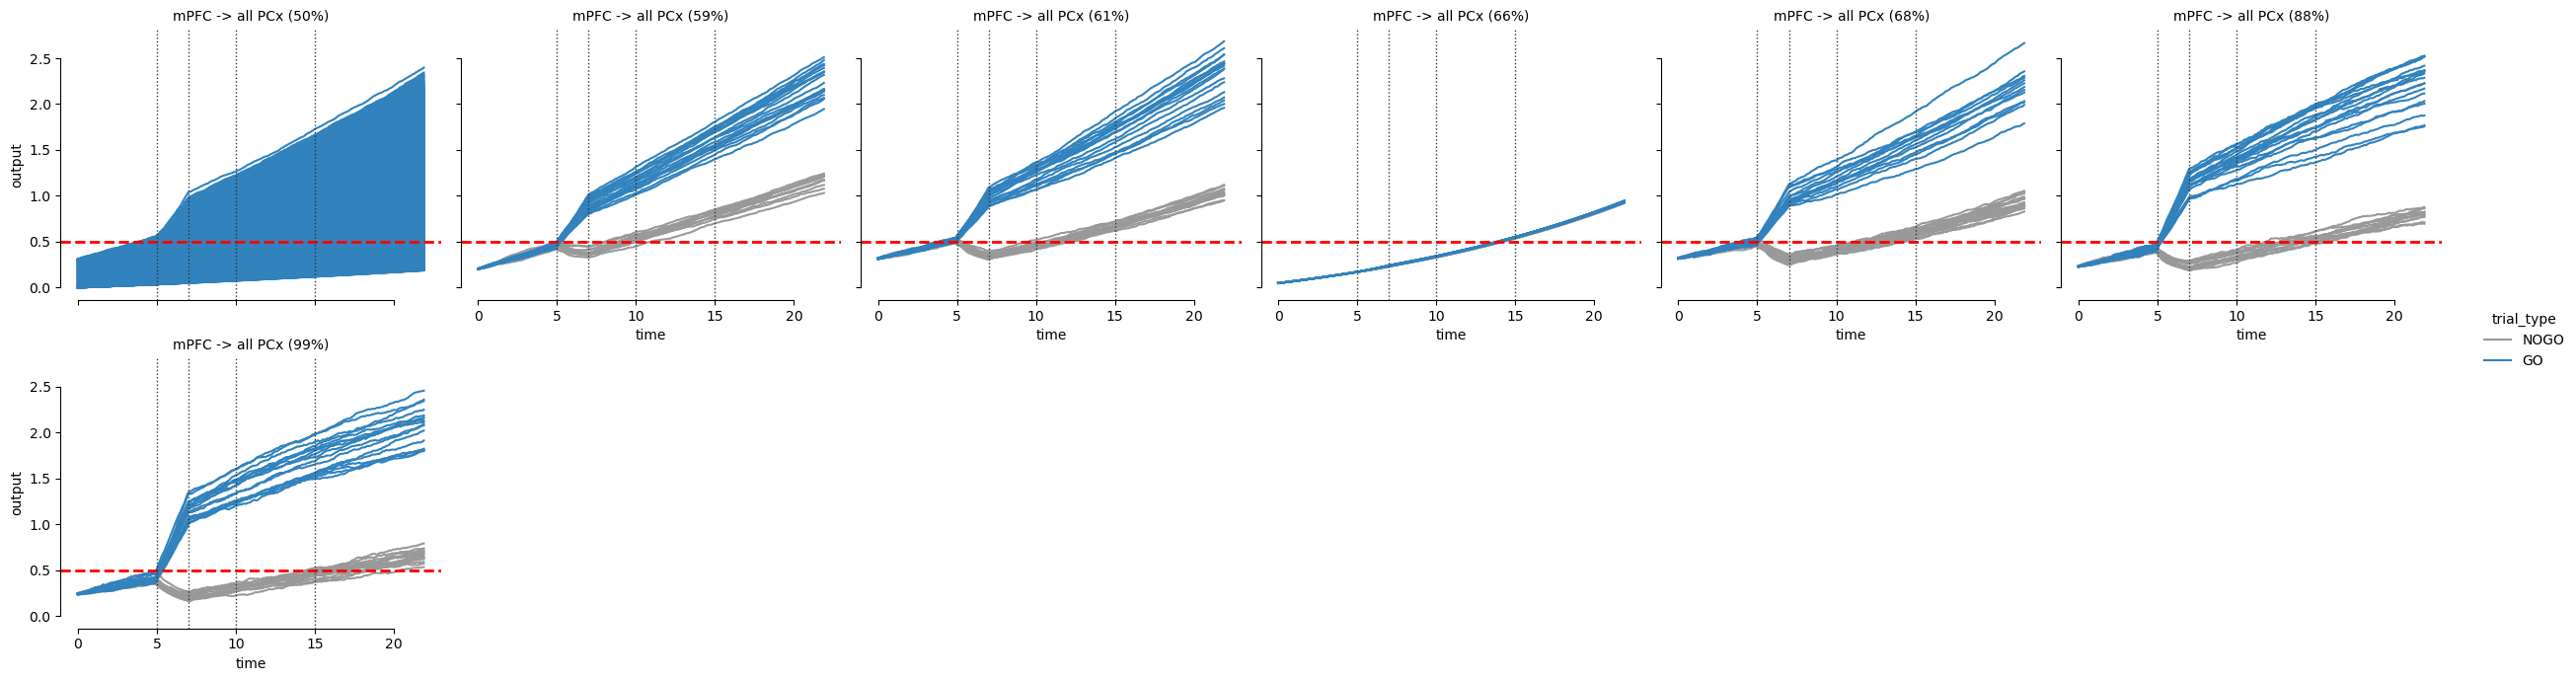

In [104]:
g = sns.relplot(
    vodf,
    x='time',
    y='output',
    units='trial', estimator=None,
    # n_boot=10,
    hue='trial_type',
    kind='line',
    col='alias',
    col_wrap=len(select_acc_levels),
    col_order=alias_order,
    height=3.5,
    lw=1.5,
    aspect=1.2,
    palette={'GO':'#3182bd', 'NOGO':'.6'}
)
g.set_titles('{col_name}')
g.refline(y=0.5,c='r',lw=2,)
[g.refline(x=x,c='.2',ls=':',lw=1) for x in [5,7,10,15]]
sns.despine(trim=True)

<Axes: xlabel='step', ylabel='loss'>

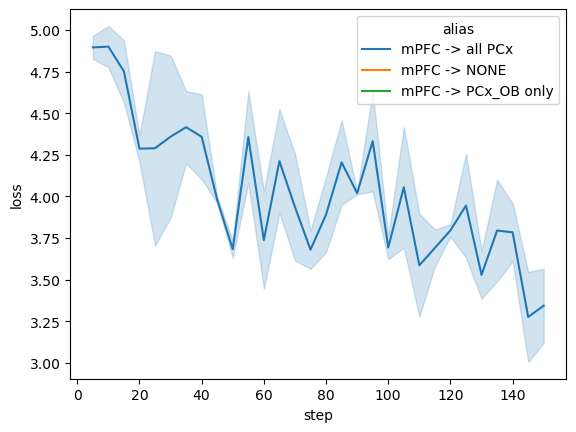

In [105]:
sns.lineplot(
    vpdf,
    x='step',
    y='loss',
    hue='alias'
)

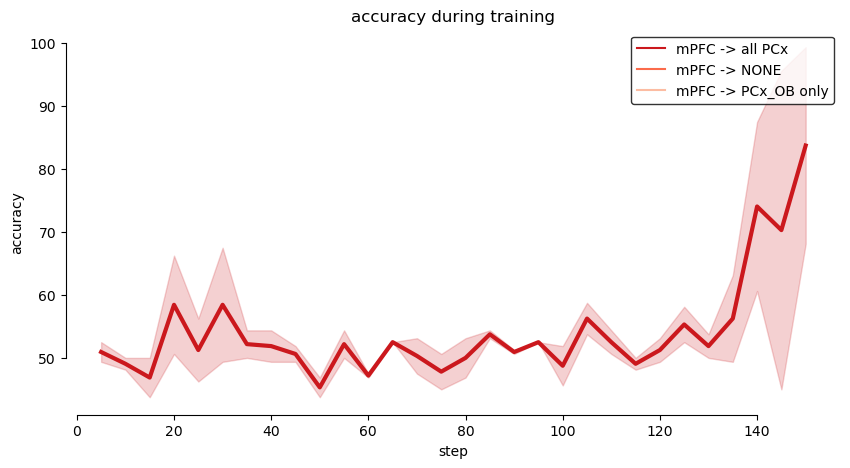

In [106]:
plt.figure(figsize=(10,5))

sns.lineplot(
    vpdf,
    x='step',
    y='accuracy',
    hue='alias',
    lw=3,
    palette='Reds_r'
)
plt.title('accuracy during training')
plt.legend(edgecolor='k')
sns.despine(trim=True)

## RNN activity

In [107]:
# !ls '/content/drive/MyDrive/Department_Indpendent_Study_Project_(NEUR)/my_code_stuff/data/experiment__20250320-115109__all/'

In [108]:
def determine_trial_accuracy(inputs, output, label, task_config):
    output_thres = task_config['lick_rate_thres']

    go_label = task_config['go_label']
    nogo_label = task_config['nogo_label']

    go_loc = task_config['go_loc']
    nogo_loc = task_config['nogo_loc']

    # TODO: need to already have saved name in generate function
    reverse_stim_map = {v: k for k, v in task_config['stim_index_map'].items()}
    input_name = reverse_stim_map[
        inputs.mean(axis=0).squeeze().argmax()
        .detach().cpu().item()
    ]

    label = label.detach().cpu().item()
    assert label in [go_label, nogo_label]

    go_output = output[go_loc].mean(axis=0).squeeze() > output_thres
    nogo_output = output[nogo_loc].mean(axis=0).squeeze() <= output_thres

    correct = go_output if label == go_label else nogo_output
    correct = correct.detach().cpu().item()

    action = 'correct' if correct else 'incorrect'

    if label == go_label:
        assert '+' in input_name
        return dict(
            stim = input_name,
            trial_type = 'GO',
            correct = correct,
            action = action,
            outcome = 'Hit' if correct else 'Miss',
        )

    if label == nogo_label:
        assert '-' in input_name
        return dict(
            stim = input_name,
            trial_type = 'NOGO',
            correct = correct,
            action = action,
            outcome = 'CR' if correct else 'FA'
        )



In [109]:
def record_activity(
    exp_dir,
    checkpoint_iter,
    num_trial = 150
):
    with open(os.path.join(exp_dir, 'config.pkl'), 'rb') as f:
        env_config = pickle.load(f)

    if checkpoint_iter not in (None, -1):
        model_path = os.path.join(
            exp_dir,
            f"models/model__checkpoint__{checkpoint_iter:06d}.pt"
        )
    else:
        ckpts = sorted(glob.glob(os.path.join(exp_dir,'models/model__checkpoint*.pt')))
        model_path = ckpts[-1]

    net = RNNNet(env_config['model']).to(device)
    net.send_mask_to_device(device)
    net.load_state_dict(torch.load(model_path))
    net.eval()

    env_config['data']['batch_size'] = 1
    records = []
    for i in tqdm(range(num_trial)):
        inputs, _, label = generate_batch_dataset(
            source_dataset,
            model_ready=True,
            device=device,
            **env_config['data']
        )
        with torch.no_grad():
            output, activity = net(inputs)
        act = activity[:,0,:].cpu().numpy()

        outcome = determine_trial_accuracy(
            inputs, output, label, env_config['task']
        )

        records.append({
            'trial': i,
            **outcome,
            'activity': act.T  # shape (hidden, )
        })

    df = pd.DataFrame(records)
    mean_acc = 100 * df['correct'].mean()
    print(f"Performance = {mean_acc:.1f}%")
    print(df['outcome'].value_counts(), '\n')

    vec = net.cell_vec
    df['population'] = [vec] * len(df)
    df['cell_id']    = [list(range(len(vec)))] * len(df)

    df = (
        df
        .explode(['activity','population','cell_id'])
        .reset_index(drop=True)
        .assign(
            exp_name = env_config['name'],
            exp_dir = exp_dir,
            checkpoint_iter = checkpoint_iter,
            mean_accuracy= mean_acc
        )
    )

    return df




activity_df = []
for exp_dir in tqdm(exp_dirs):
    activity_df.append(record_activity(
        exp_dir,
        checkpoint_iter = 50,
        num_trial = 150
    ))

 50%|█████     | 1/2 [00:05<00:05,  5.07s/it]

Performance = 44.7%
outcome
FA     83
Hit    67
Name: count, dtype: int64 




100%|██████████| 2/2 [00:10<00:00,  5.06s/it]

Performance = 47.3%
outcome
FA     79
Hit    71
Name: count, dtype: int64 



In [110]:
df = pd.concat(activity_df, ignore_index=True)

In [111]:
group_col = 'outcome'

mdf = (
    df.groupby([
        'exp_name', 'checkpoint_iter', 'mean_accuracy',
        'cell_id', 'population', group_col
    ])
    ['activity'].agg(
        lambda x: np.mean(np.vstack(list(x)), axis=0)
    )
    .reset_index()
)
mdf['time'] = [env_config['task']['clock']] * len(mdf)

mdf = (
    mdf.explode(['time', 'activity'])
    .reset_index(drop=True)
)

mdf

,exp_name,checkpoint_iter,mean_accuracy,cell_id,population,outcome,activity,time
0,all,50,44.666667,0,OB,FA,0.000054,0.0
1,all,50,44.666667,0,OB,FA,0.00007,0.1
2,all,50,44.666667,0,OB,FA,0.000103,0.2
3,all,50,44.666667,0,OB,FA,0.000128,0.3
4,all,50,44.666667,0,OB,FA,0.000156,0.4
...,...,...,...,...,...,...,...,...
82715,all,50,47.333333,59,mPFC,Hit,0.149086,21.5
82716,all,50,47.333333,59,mPFC,Hit,0.149815,21.6
82717,all,50,47.333333,59,mPFC,Hit,0.150545,21.7
82718,all,50,47.333333,59,mPFC,Hit,0.151275,21.8


In [112]:
mdf['alias'] = mdf.apply(
    lambda x: alias_map[x['exp_name']] + ' (%.0f%%)' %(x['mean_accuracy']),
    axis=1
)

/oscar/rt/9.2/software/0.20-generic/0.20.1/opt/spack/linux-rhel9-x86_64_v3/gcc-11.3.1/anaconda-2023.09-0-7nso27ys7navjquejqdxqylhg7kuyvxo/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/oscar/rt/9.2/software/0.20-generic/0.20.1/opt/spack/linux-rhel9-x86_64_v3/gcc-11.3.1/anaconda-2023.09-0-7nso27ys7navjquejqdxqylhg7kuyvxo/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/oscar/rt/9.2/software/0.20-generic/0.20.1/opt/spack/linux-rhel9-x86_64_v3/gcc-11.3.1/anaconda-2023.09-0-7nso27ys7navjquejqdxqylhg7kuyvxo/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/oscar/rt/9.2/software/0.20-generic/0.20.1/opt/spack/linux-rhel9-x86_64_v3/gcc-11.3.1/anaconda-2023.09-0-7nso27ys7navjquejqdxqylhg7ku

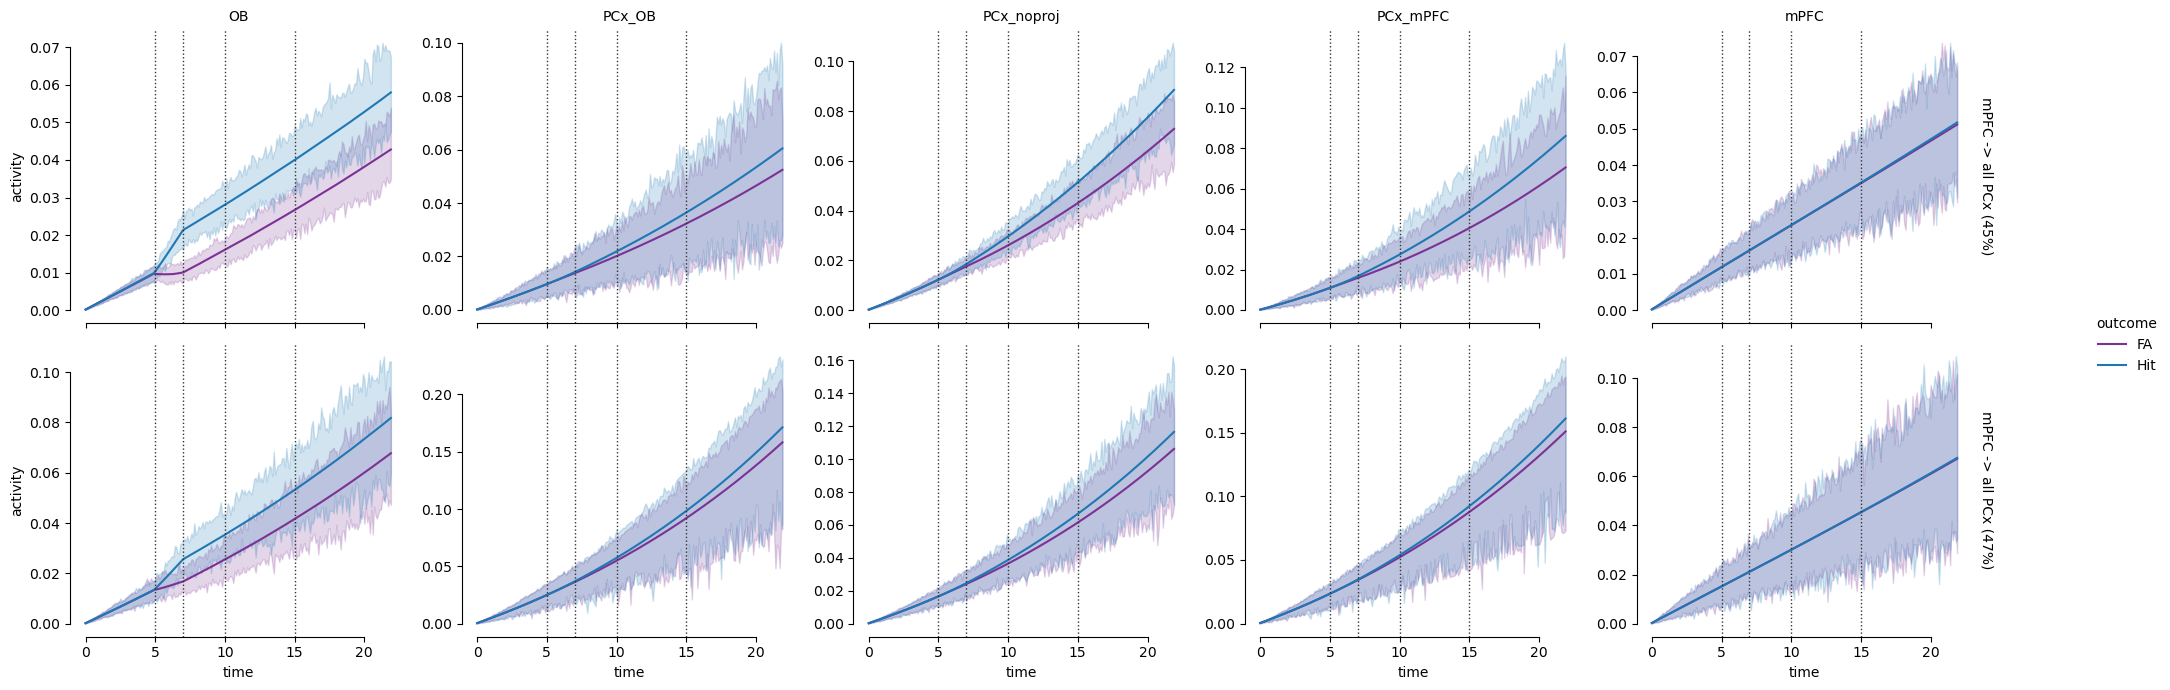

In [113]:
outcome_cmap = {
    'Hit':'#1f78b4',
    'CR':'#008837',
    'FA':'#7b3294',
    'Miss': '#e31a1c'
}

g = sns.relplot(
    mdf,
    x='time',
    y='activity',
    hue='outcome',
    palette=outcome_cmap,
    col='population',
    kind='line',
    row='alias',
    n_boot=50,
    height=3.5,
    aspect=1.2,
    facet_kws={'sharey':False, 'margin_titles':True}
)

g.set_titles(col_template='{col_name}', row_template='{row_name}')
[g.refline(x=x,c='.2',ls=':',lw=1) for x in [5,7,10,15]]
sns.despine(trim=True)


In [116]:
exp_dir = root_data_dir + '/experiment__20250516-173843__all'

with open(os.path.join(exp_dir, 'config.pkl'), 'rb') as f:
    env_config = pickle.load(f)

In [117]:
env_config['name']

'all'

In [118]:
model_path = os.path.join(exp_dir,'models/model__checkpoint__000015.pt')

In [119]:
print(exp_dir)
net = RNNNet(env_config['model'],
).to(device)
net.send_mask_to_device(device)
net.load_state_dict(torch.load(model_path, weights_only=True))
net.eval()

data/tfarnpin/rnn/experiment__20250516-173843__all


RNNNet(
  (rnn): CTRNN(
    (input2h): Linear(in_features=4, out_features=60, bias=True)
    (h2h): Linear(in_features=60, out_features=60, bias=True)
  )
  (fc): Linear(in_features=60, out_features=1, bias=True)
)

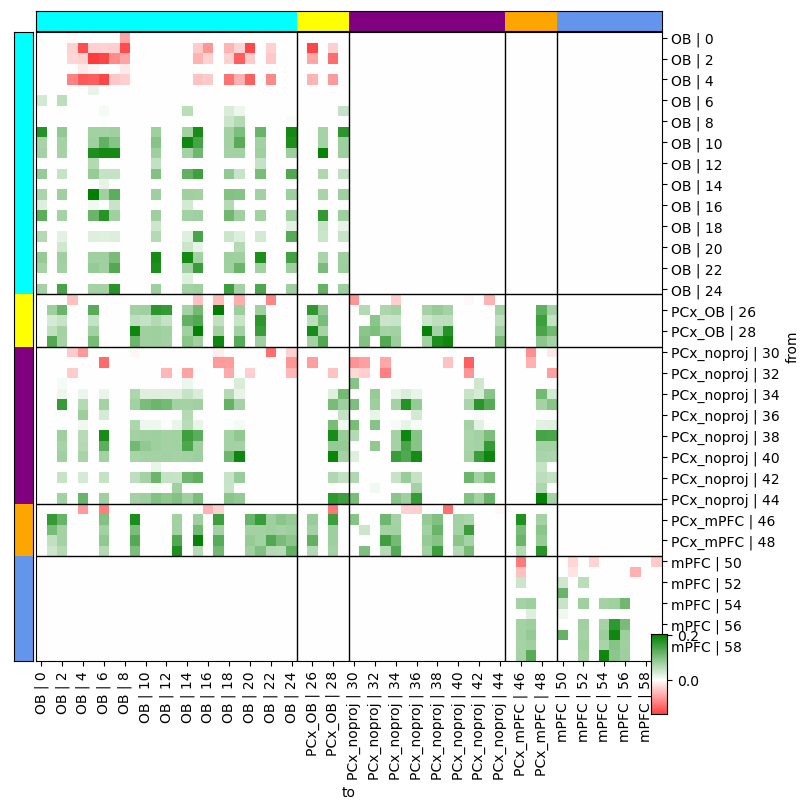

In [120]:
plot_weight_matrix(net)

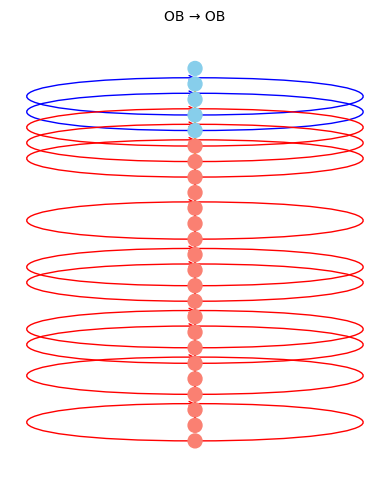

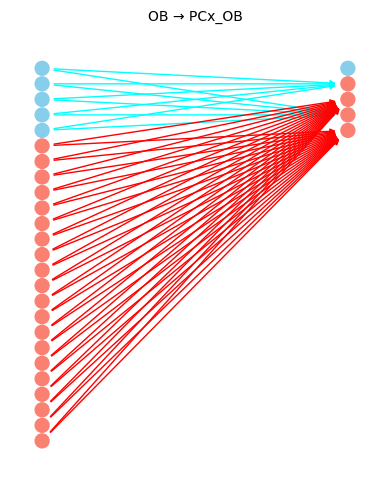

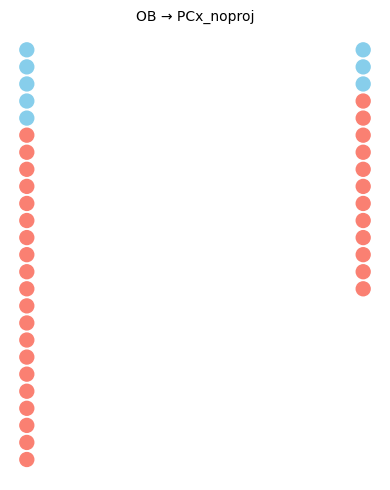

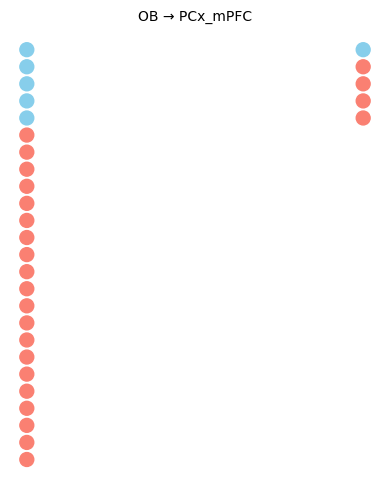

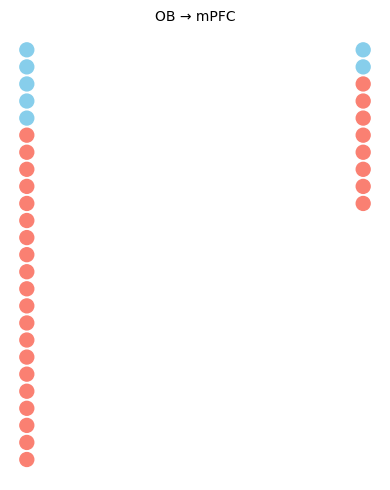

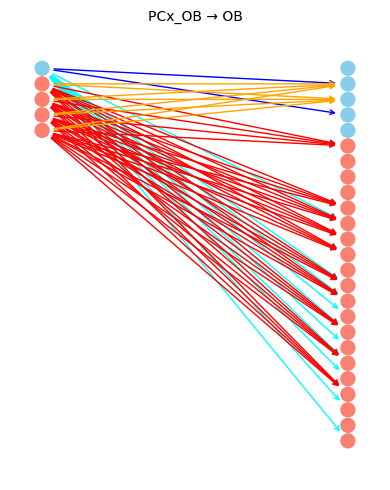

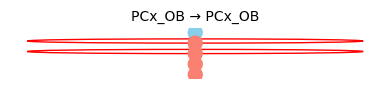

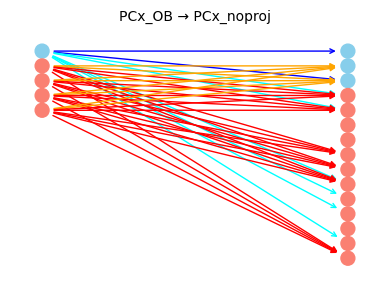

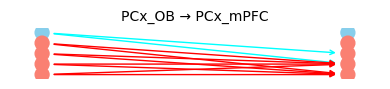

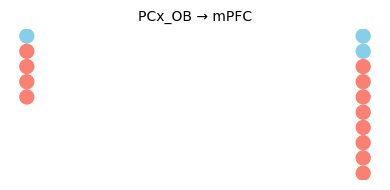

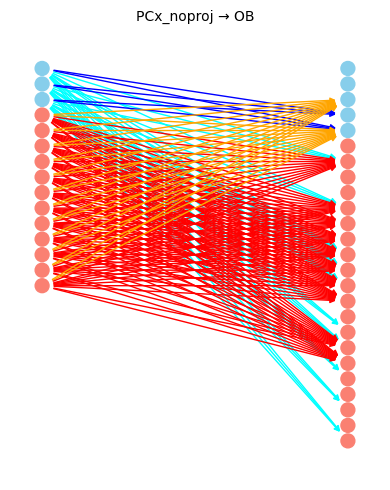

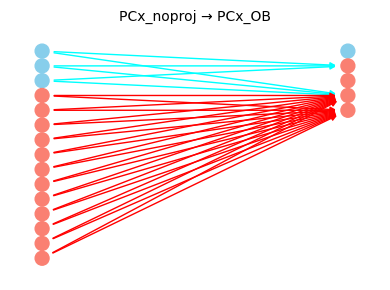

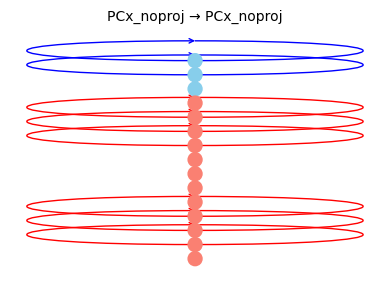

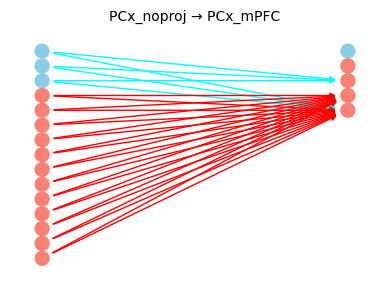

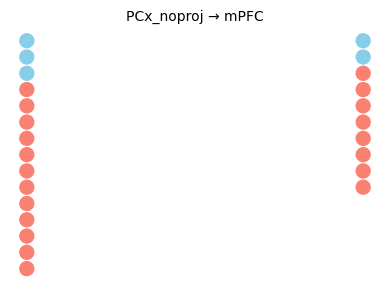

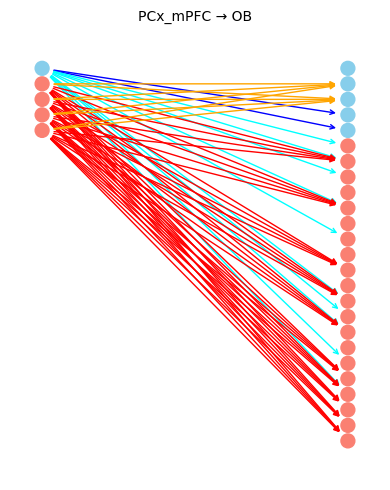

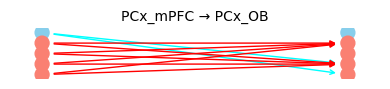

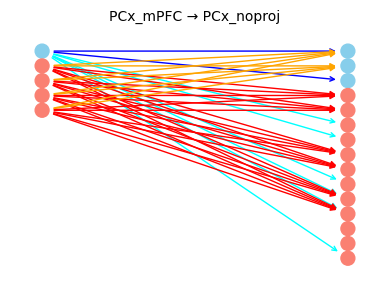

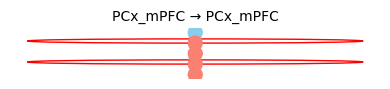

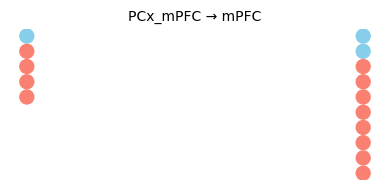

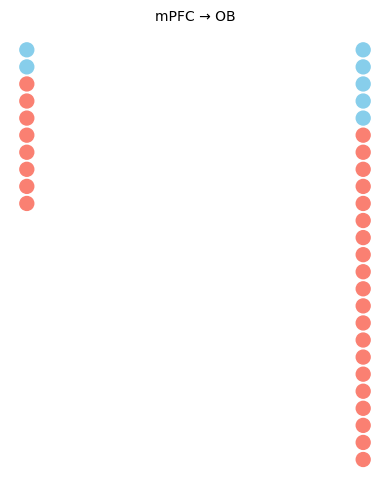

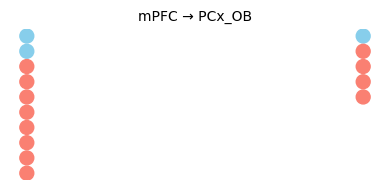

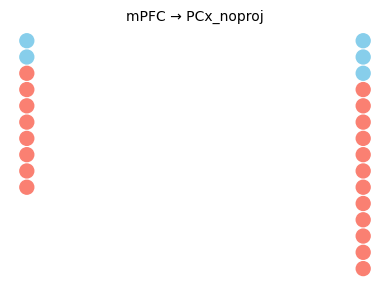

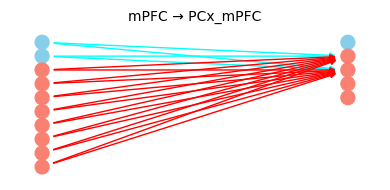

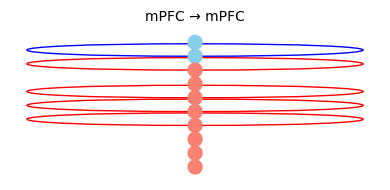

In [121]:
import networkx as nx
import matplotlib.pyplot as plt

mask = net.mask['h2h_w'].bool().cpu().numpy()
signs = net.neuron_signs.cpu().numpy()

regions = list(net.pop_slices.keys())
pop = net.pop_slices

node_color_map = { 'inh':'skyblue', 'exc':'salmon' }
edge_color_map = { 'ii':'blue','ie':'cyan','ei':'orange','ee':'red' }

for src in regions:
    for tgt in regions:
        sl_i = pop[src]; sl_j = pop[tgt]
        if sl_i.stop==sl_i.start or sl_j.stop==sl_j.start:
            continue

        src_idx = list(range(sl_i.start, sl_i.stop))
        tgt_idx = list(range(sl_j.start, sl_j.stop))

        G = nx.DiGraph()

        for i in src_idx:
            sign = 'inh' if signs[i]<0 else 'exc'
            G.add_node(i, sign=sign, bipartite=0)

        for j in tgt_idx:
            sign = 'inh' if signs[j]<0 else 'exc'
            G.add_node(j, sign=sign, bipartite=1)

        for i in src_idx:
            for j in tgt_idx:
                if mask[i,j]:
                    if signs[i]<0 and signs[j]<0: etype='ii'
                    elif signs[i]<0 and signs[j]>0: etype='ie'
                    elif signs[i]>0 and signs[j]<0: etype='ei'
                    else:                            etype='ee'
                    G.add_edge(i, j, type=etype)

        pos = {}

        ypos_src = list(range(len(src_idx)))
        ypos_tgt = list(range(len(tgt_idx)))
        
        for idx, i in enumerate(src_idx):
            pos[i] = (0, -ypos_src[idx])
        for idx, j in enumerate(tgt_idx):
            pos[j] = (1, -ypos_tgt[idx])


        plt.figure(figsize=(4, max(len(src_idx),len(tgt_idx))*0.2))

        nx.draw_networkx_nodes(
            G, pos,
            node_color=[node_color_map[data['sign']] for _,data in G.nodes(data=True)],
            node_size=100
        )

        nx.draw_networkx_edges(
            G, pos,
            edge_color=[edge_color_map[data['type']] for _,_,data in G.edges(data=True)],
            arrowsize=8, arrowstyle='->'
        )

        plt.title(f"{src} → {tgt}", fontsize=10)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

              OB  PCx_OB  PCx_noproj  PCx_mPFC  mPFC
OB          0.48     0.4    0.000000       0.0   0.0
PCx_OB      0.48     0.4    0.533333       0.4   0.0
PCx_noproj  0.48     0.4    0.533333       0.4   0.0
PCx_mPFC    0.48     0.4    0.533333       0.4   0.0
mPFC        0.00     0.0    0.000000       0.4   0.5
Plotting OB → OB
Plotting OB → PCx_OB
Plotting OB → PCx_noproj
Plotting OB → PCx_mPFC
Plotting OB → mPFC
Plotting PCx_OB → OB
Plotting PCx_OB → PCx_OB
Plotting PCx_OB → PCx_noproj
Plotting PCx_OB → PCx_mPFC
Plotting PCx_OB → mPFC
Plotting PCx_noproj → OB
Plotting PCx_noproj → PCx_OB
Plotting PCx_noproj → PCx_noproj
Plotting PCx_noproj → PCx_mPFC
Plotting PCx_noproj → mPFC
Plotting PCx_mPFC → OB
Plotting PCx_mPFC → PCx_OB
Plotting PCx_mPFC → PCx_noproj
Plotting PCx_mPFC → PCx_mPFC
Plotting PCx_mPFC → mPFC
Plotting mPFC → OB
Plotting mPFC → PCx_OB


/tmp/ipykernel_3565626/1832316244.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5, 4))


Plotting mPFC → PCx_noproj
Plotting mPFC → PCx_mPFC
Plotting mPFC → mPFC


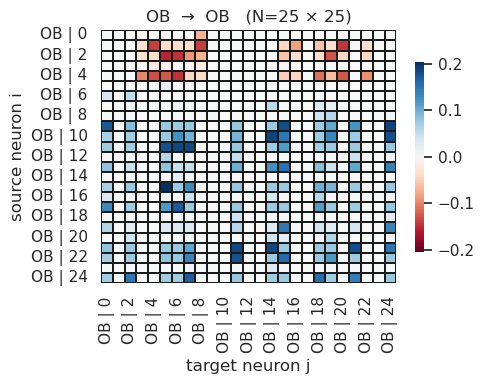

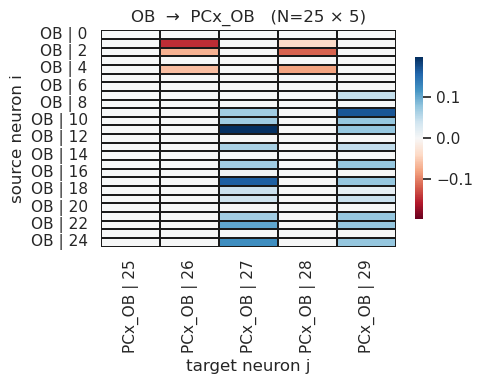

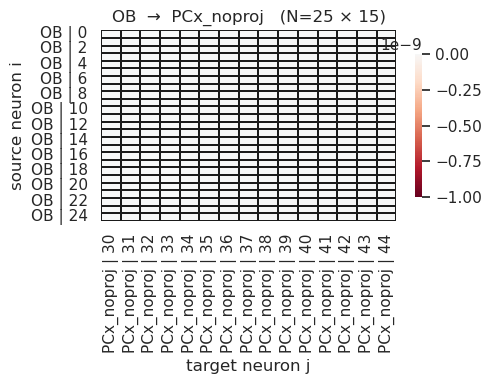

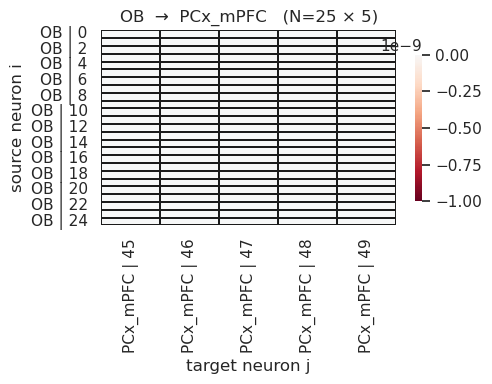

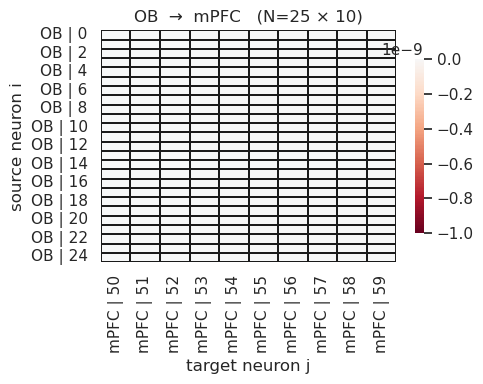

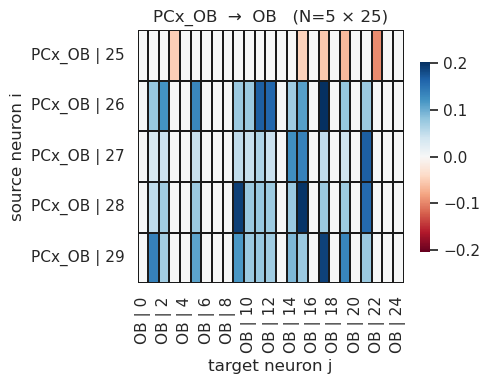

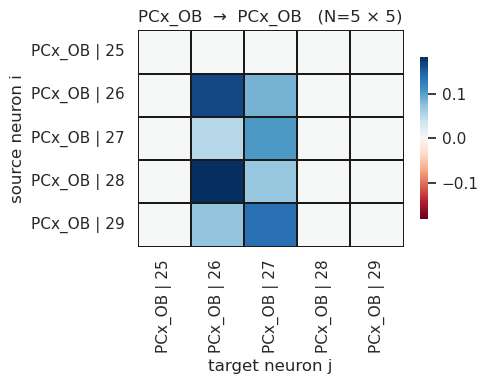

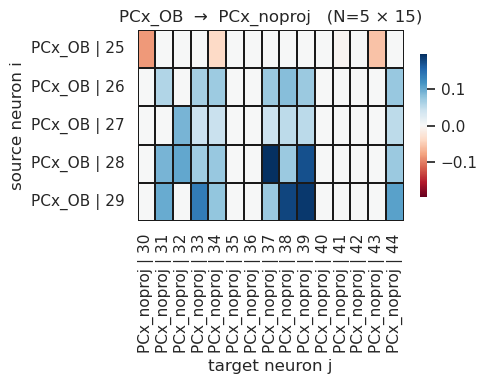

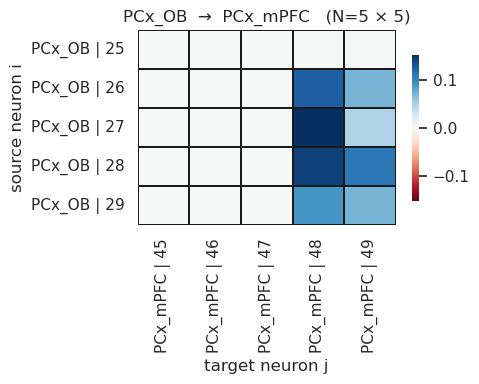

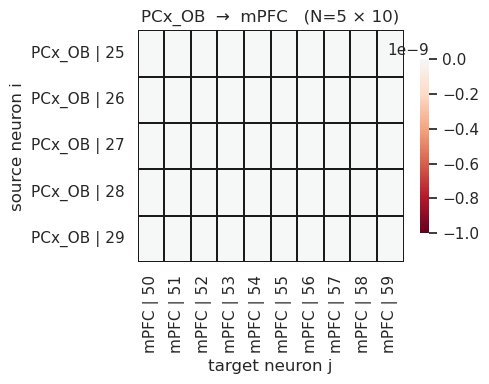

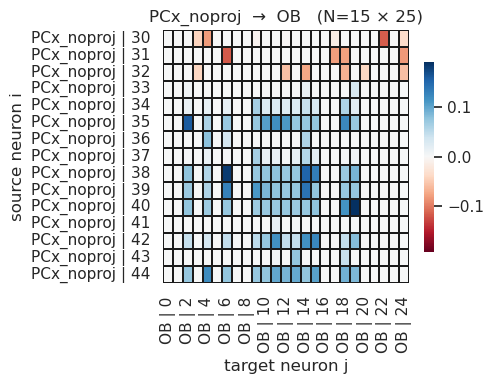

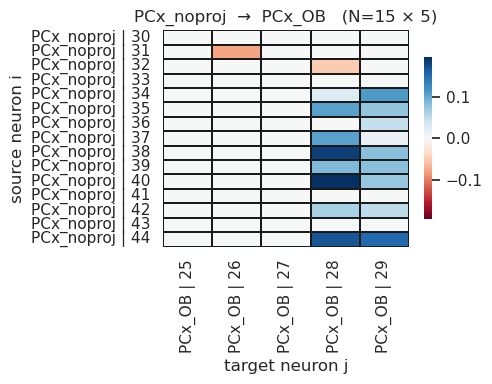

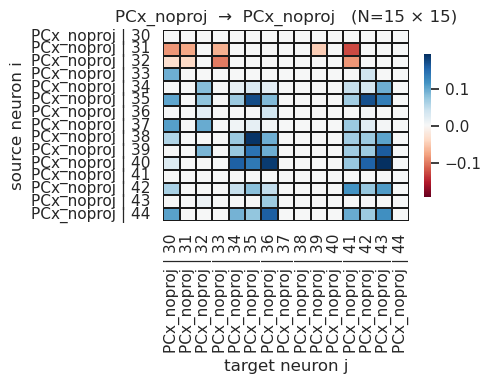

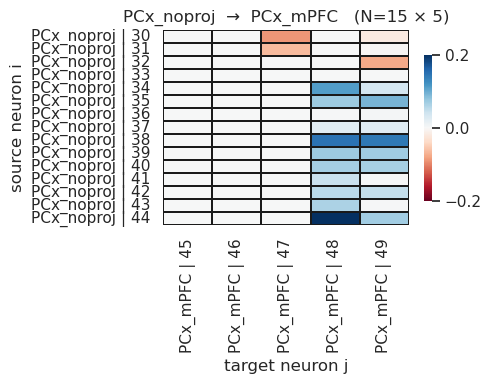

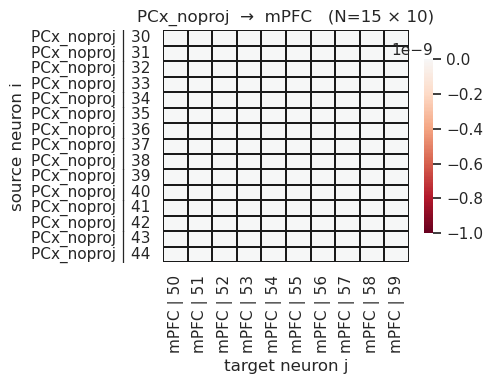

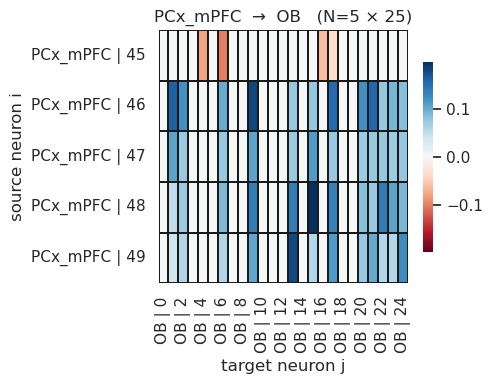

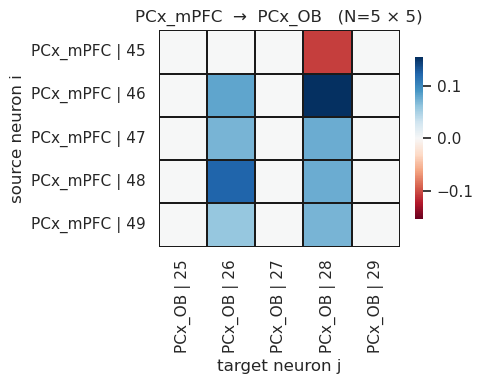

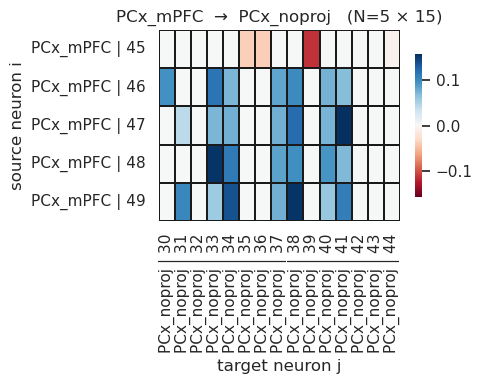

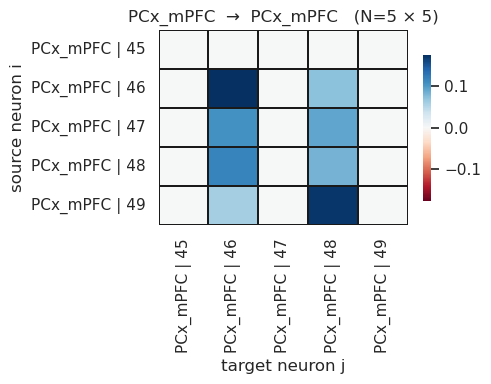

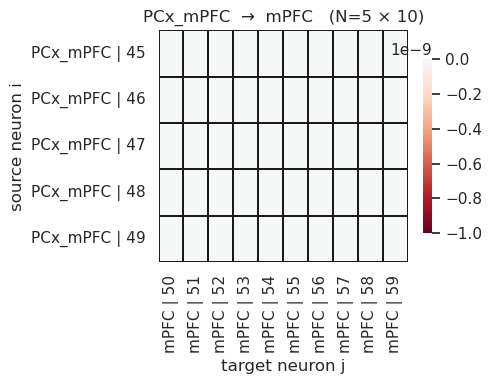

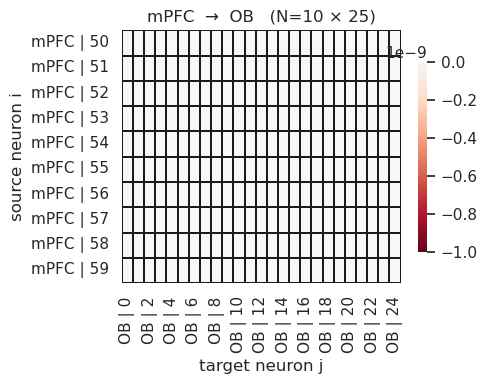

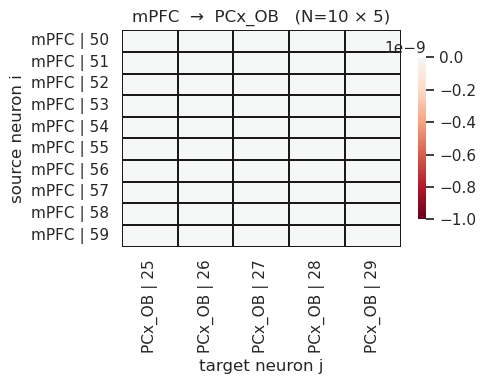

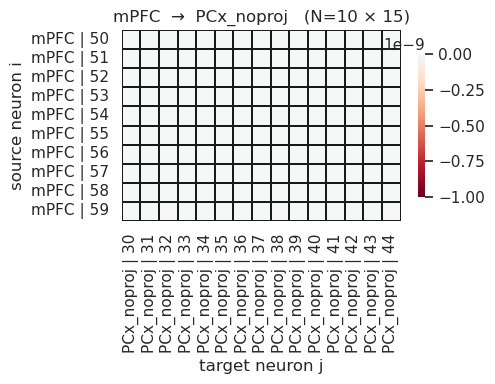

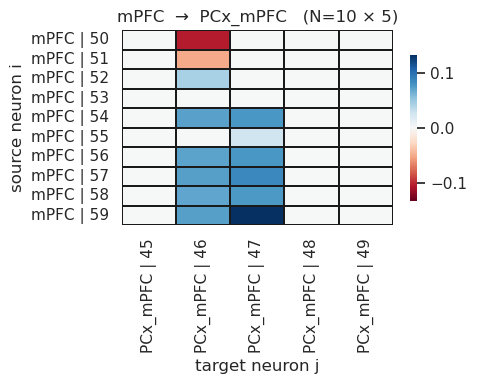

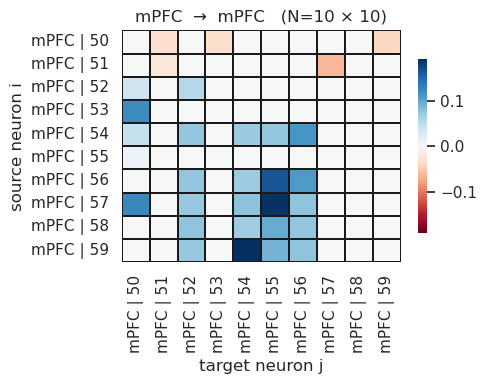

In [122]:
import pandas as pd
names = ['OB', 'PCx_OB', 'PCx_noproj', 'PCx_mPFC', 'mPFC']
mat = torch.zeros(len(names), len(names))
for i, src in enumerate(names):
    for j, tgt in enumerate(names):
        blk = net.mask['h2h_w'][
            net.pop_slices[src],
            net.pop_slices[tgt]
        ]
        mat[i, j] = blk.mean()    
print(pd.DataFrame(mat.numpy(), index=names, columns=names))

def plot_region_block(net,
                      src_region: str,
                      tgt_region: str,
                      use_effective=True,
                      show_fig=True,
                      save_path=None):

    rows = net.pop_slices[src_region]
    cols = net.pop_slices[tgt_region]

    W = net.rnn.h2h.weight.detach()
    if use_effective:
        W = W * net.mask['h2h_w']        
    block = W[rows, cols].cpu().numpy()

    vmax = np.abs(block).max()
    vmin = -vmax if vmax != 0 else -1e-9  


    src_labels = [f"{src_region} | {i}" for i in range(rows.start, rows.stop)]
    tgt_labels = [f"{tgt_region} | {i}" for i in range(cols.start, cols.stop)]

    # ###################### #
    sns.set(style="white")
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        pd.DataFrame(block, index=src_labels, columns=tgt_labels),
        cmap="RdBu", vmin=vmin, vmax=vmax, center=0,
        cbar_kws=dict(shrink=0.75),
        square=False, linewidths=0.25, linecolor="k"
    )
    
    
    
    plt.title(f"{src_region}  →  {tgt_region}   (N={len(src_labels)} × {len(tgt_labels)})")
    plt.xlabel("target neuron j")
    plt.ylabel("source neuron i")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    if not show_fig:
        plt.close()

regions = ["OB", "PCx_OB", "PCx_noproj", "PCx_mPFC", "mPFC"]

for src in regions:            
    for tgt in regions:        
        print(f"Plotting {src} → {tgt}")
        plot_region_block(
            net,
            src_region=src,
            tgt_region=tgt,
            use_effective=True,                  
            show_fig=True,                       

        )

In [127]:
num_trial = 1000

data = []

env_config['data']['batch_size'] = 1
for i in tqdm(range(num_trial)):
    # Inputs
    inputs, _, label = generate_batch_dataset(
        source_dataset,
        model_ready=True,
        device=device,
        **env_config['data']
    )

    # RNN
    with torch.no_grad():
        model_output, rnn_activity = net(inputs)
    rnn_activity = rnn_activity[:,0,:].cpu().detach().numpy()

    # Outcome
    ouctome = determine_trial_accuracy(
        inputs,
        model_output,
        label,
        env_config['task']
    )


    data.append(dict(
        trial = i,
        **ouctome,
        activity = rnn_activity.T,
    ))

100%|██████████| 1000/1000 [00:33<00:00, 29.74it/s]


In [134]:
df = pd.DataFrame(data)
print(f"Performance = {100*df['correct'].mean()} %")
print(df['outcome'].value_counts())

cell_vec = net.cell_vec

df['population'] = [cell_vec] * len(df)
df['cell_id'] = [range(len(cell_vec))] * len(df)

df = df.explode(['activity','cell_id','population']).reset_index(drop=True)



Performance = 51.2 %
outcome
CR      512
Miss    488
Name: count, dtype: int64


In [135]:
df

,trial,stim,trial_type,correct,action,outcome,activity,population,cell_id
0,0,CS-2,NOGO,True,correct,CR,"[0.0, 3.4263106e-05, 8.794522e-05, 7.102178e-0...",OB,0
1,0,CS-2,NOGO,True,correct,CR,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.197954e-05, 0...",OB,1
2,0,CS-2,NOGO,True,correct,CR,"[0.0, 4.2764284e-05, 8.754138e-05, 0.0, 0.0, 0...",OB,2
3,0,CS-2,NOGO,True,correct,CR,"[0.00010906388, 6.7810826e-05, 0.0, 0.0, 0.000...",OB,3
4,0,CS-2,NOGO,True,correct,CR,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",OB,4
...,...,...,...,...,...,...,...,...,...
59995,999,CS-1,NOGO,True,correct,CR,"[0.0, 1.7168036e-08, 5.1459683e-08, 1.02826775...",mPFC,55
59996,999,CS-1,NOGO,True,correct,CR,"[0.00033896122, 0.00067742536, 0.0010153932, 0...",mPFC,56
59997,999,CS-1,NOGO,True,correct,CR,"[0.00015108312, 0.00030203152, 0.00045284536, ...",mPFC,57
59998,999,CS-1,NOGO,True,correct,CR,"[0.00015350018, 0.000306851, 0.00046005263, 0....",mPFC,58


In [136]:
group_col = 'outcome'

mdf = (
    df.groupby([
        'cell_id', 'population', group_col
    ])
    ['activity'].agg(
        lambda x: np.mean(np.vstack(list(x)), axis=0)
    )
    .reset_index()
)
mdf['time'] = [env_config['task']['clock']] * len(mdf)

mdf = (
    mdf.explode(['time', 'activity'])
    .reset_index(drop=True)
)

mdf

,cell_id,population,outcome,activity,time
0,0,OB,CR,0.000005,0.0
1,0,OB,CR,0.000007,0.1
2,0,OB,CR,0.000009,0.2
3,0,OB,CR,0.000008,0.3
4,0,OB,CR,0.000006,0.4
...,...,...,...,...,...
26395,59,mPFC,Miss,0.072215,21.5
26396,59,mPFC,Miss,0.072503,21.6
26397,59,mPFC,Miss,0.072791,21.7
26398,59,mPFC,Miss,0.073079,21.8


/oscar/rt/9.2/software/0.20-generic/0.20.1/opt/spack/linux-rhel9-x86_64_v3/gcc-11.3.1/anaconda-2023.09-0-7nso27ys7navjquejqdxqylhg7kuyvxo/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


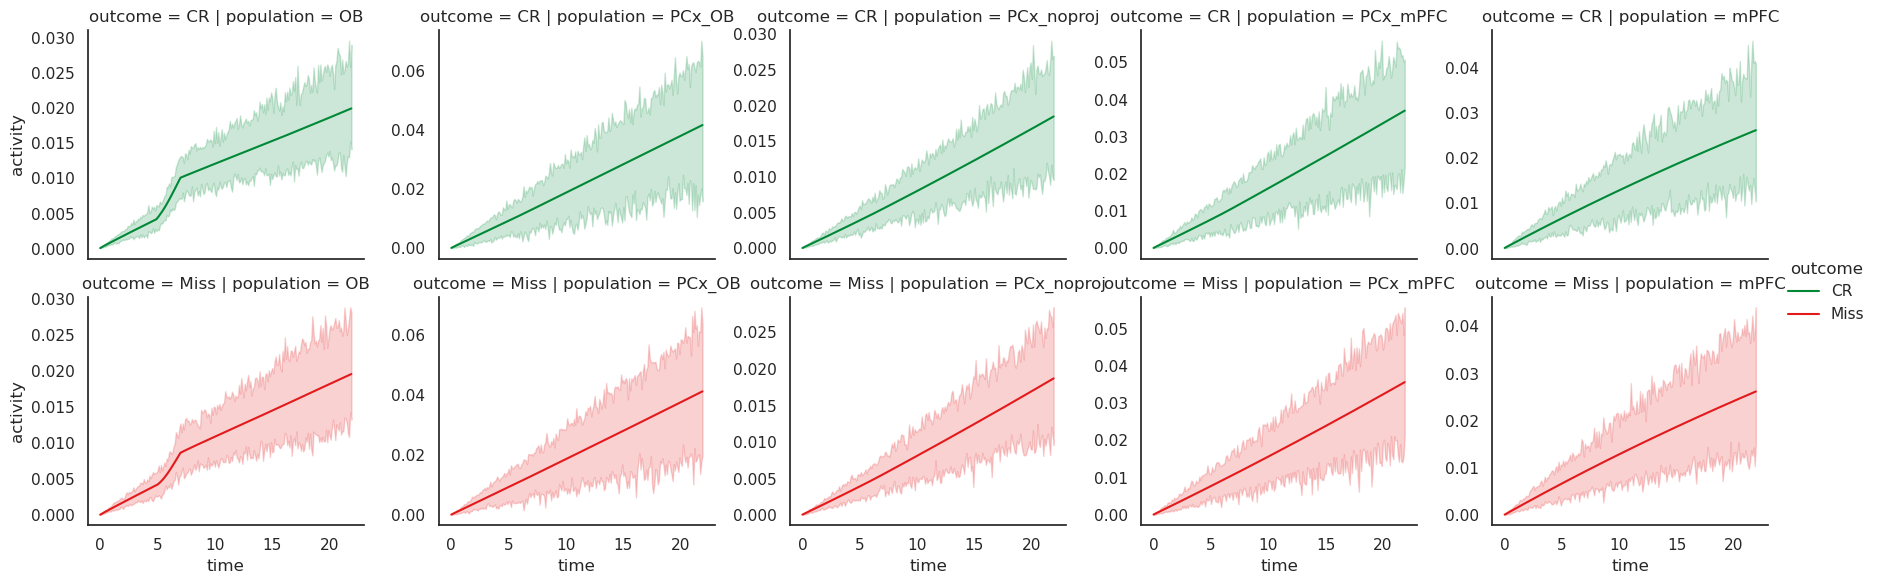

In [137]:
outcome_cmap = {
    'Hit':'#1f78b4',
    'CR':'#008837',
    'FA':'#7b3294',
    'Miss': '#e31a1c'
}

sns.relplot(
    mdf,
    x='time',
    y='activity',
    # hue='cell_id',
    hue='outcome',
    palette=outcome_cmap,
    col='population',
    kind='line',
    row='outcome',
    # errorbar=('sd',3)
    n_boot=50,
    height=3,
    aspect=1.2,
    facet_kws={'sharey':False}
)


##Pickle

In [138]:
import pickle

file_path = root_data_dir + '/experiment__20250407-073152__all/checkpoints/checkpoint_iter_000055.pkl'

with open(file_path, 'rb') as file:
    data = pickle.load(file)

print(type(data))
print(data)

if isinstance(data, dict):
    print("\nKeys in the dictionary:")
    for key in data.keys():
        print(f"- {key} ({type(data[key])})")

FileNotFoundError: [Errno 2] No such file or directory: 'data/tfarnpin/rnn/experiment__20250407-073152__all/checkpoints/checkpoint_iter_000055.pkl'

In [139]:
print("DONE")

DONE
